# Contexto comercial

## Abstract

En el siguiente trabajo se analiza un dataset con información sobre las calificaciones de exámenes de secundaria de alrededor de 30.000 alumnos, así como ciertas características socioeconómicas de los mismos, como sexo, etnicidad, estudios de los padres, y otras variables que se explicarán más con detalle en la sección correspondiente. Se intenta explicar si dichas características pueden tener influencia o no en la probabilidad de un alumno para aprobar los exámenes (obtener 50 puntos o más) o exonerar las materias (obtener 70 o más).

Con la educación siendo un importante indicador para el éxito económico y social de las naciones, y teniendo en cuenta que varios países de Latinoamérica están experimentando reformas educativas en este momento, o tienen planes de hacerlo en el corto plazo, parece oportuno identificar áreas fuera de lo que es estrictamente educativo que puedan estar alterando los resultados educativos. Además, un modelo que pueda estimar un resultado educativo promedio de un grupo de estudiantes en un centro educativo puede ayudar a encarar posibles problemas antes de que se hagan evidentes como resultado de exámenes.

## Preguntas a responder

Con este análisis se intentan responder preguntas como ¿Son estadísticamente significativas las diferencias de sexo, etnicidad, educación de los padres, etc, para explicar las diferencias en los resultados educativos de los alumnos? ¿Es posible predecir si un alumno tiene mayor probabildiad de aprobar las pruebas o exonerar los cursos basado en variables diferentes a la cantidad de horas de estudio del alumno?

# Importación de librerías

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.formula.api as sm
import statsmodels.api as smod
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Carga del dataset y análisis exploratorio de datos (EDA)

## Carga y modificación del dataset: Puntuación de exámenes en secundaria.

Fuente: Kaggle.

La base de datos presenta información de más de 30.000 estudiantes de secundaria en Estados Unidos.

Descripción de las variables:

* ID = Identificador del estudiante
* Sexo = Sexo del estudiante (masculino o femenino)
* Etnia = Etnia del estudiante, dividido en 5 grupos (Grupo A a E, no aclara en la base de datos cuál es cada etnicidad pero se podría asumir de A a E como las 5 más comunes en EEUU, en orden como porcentaje de población serían Blanco, Afroamericano, Hispano, Asiático, Nativo Americano. Se le dará nombre en la base de datos cuando se realicen las estadísticas descriptivas de mayor a menor frecuencia en el orden anteriormente mencionado)
* Educ_padres = Nivel educativo de los padres del estudiante, toma los valores de liceo incompleto, liceo completo, terciarios incompeltos, estudios técnicos y diploma universitario.
* Tipo_almuerzo = Indica si el estudiante consume el almuerzo estándar o el reducido/gratis.
* Curso_prep = Indica si el estudiante completó o no el curso de preparación para los exámenes.
* Estado_civil_padres = Indica si los padres están casados, divorciados, viudos o si son padres solteros.
* Deporte = Indica si el estudiante practica deportes, varía entre nunca, a veces y regularmente.
* Primer_hijo = Indica "Si" si el estudiante fue el primer hijo de la familia, "No" de lo contrario.
* Hermanos = Indica el número de hermanos del estudiante.
* Transporte = Indica si el estudiante va a la institución educativa en el bus escolar o en transporte privado.
* Estudio_semanal = Indica las horas semanales de estudio que dedica en promedio el estudiante. Varia entre <5, 5-10 y >10.
* Score_mat = Indica el puntaje en la prueba de matemáticas (sobre 100)
* Score_lect = Indica el puntaje en la prueba de lectura (sobre 100)
* Score_esc = Indica el puntaje en la prueba de escritura (sobre 100)

La idea con la base de datos sería poder explicar factores que influyan en las calificaciones de los estudiantes que vayan más allá de las horas de estudio dedicadas. Factores familiares como puede ser el estado civil de los padres o la cantidad de hermanos, y tal vez factores económicos que se pueden conseguir utilizando proxys. Por ejemplo una combinación de ir en bus escolar y consumir almuerzo reducido/gratuito podría ser un indicador de nivel económico menor en la casa.


In [73]:
url = 'https://raw.githubusercontent.com/NicolasCladera/CODER/main/Expanded_data_with_more_features.csv'

score = pd.read_csv(url
                    , names = [ "ID"
                              , "Sexo"
                              , "Etnia"
                              , "Educ_padres"
                              , "Tipo_almuerzo"
                              , "Curso_prep"
                              , "Estado_civil_padres"
                              , "Deporte"
                              , "Primer_hijo"
                              , "Hermanos"
                              , "Transporte"
                              , "Estudio_semanal"
                              , "Score_mat"
                              , "Score_lect"
                              , "Score_esc"]
                    , header = 0
                    )

score['ID'] = range(1, 30642)
score.set_index('ID', inplace = True)

score

,Sexo,Etnia,Educ_padres,Tipo_almuerzo,Curso_prep,Estado_civil_padres,Deporte,Primer_hijo,Hermanos,Transporte,Estudio_semanal,Score_mat,Score_lect,Score_esc
ID,,,,,,,,,,,,,,
1,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
2,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
3,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
4,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
5,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30637,female,group D,high school,standard,none,single,sometimes,no,2.0,school_bus,5 - 10,59,61,65
30638,male,group E,high school,standard,none,single,regularly,no,1.0,private,5 - 10,58,53,51
30639,female,NaN,high school,free/reduced,completed,married,sometimes,no,1.0,private,5 - 10,61,70,67


In [74]:
print(score.dtypes)

for i in score.columns:
  if score[i].dtypes == object:
    score[i] = score[i].astype('string')
  else:
    pass

print(score.dtypes)

Sexo                    object
Etnia                   object
Educ_padres             object
Tipo_almuerzo           object
Curso_prep              object
Estado_civil_padres     object
Deporte                 object
Primer_hijo             object
Hermanos               float64
Transporte              object
Estudio_semanal         object
Score_mat                int64
Score_lect               int64
Score_esc                int64
dtype: object
Sexo                    string
Etnia                   string
Educ_padres             string
Tipo_almuerzo           string
Curso_prep              string
Estado_civil_padres     string
Deporte                 string
Primer_hijo             string
Hermanos               float64
Transporte              string
Estudio_semanal         string
Score_mat                int64
Score_lect               int64
Score_esc                int64
dtype: object


In [75]:
print(score.dtypes)

Sexo                    string
Etnia                   string
Educ_padres             string
Tipo_almuerzo           string
Curso_prep              string
Estado_civil_padres     string
Deporte                 string
Primer_hijo             string
Hermanos               float64
Transporte              string
Estudio_semanal         string
Score_mat                int64
Score_lect               int64
Score_esc                int64
dtype: object


Se realizan algunas estadísticas descriptivas para tener una idea general de los datos

In [76]:
score.describe().round(1)

,Hermanos,Score_mat,Score_lect,Score_esc
count,29069.0,30641.0,30641.0,30641.0
mean,2.1,66.6,69.4,68.4
std,1.5,15.4,14.8,15.4
min,0.0,0.0,10.0,4.0
25%,1.0,56.0,59.0,58.0
50%,2.0,67.0,70.0,69.0
75%,3.0,78.0,80.0,79.0
max,7.0,100.0,100.0,100.0


In [77]:
score.describe(include = 'string').round(1)

,Sexo,Etnia,Educ_padres,Tipo_almuerzo,Curso_prep,Estado_civil_padres,Deporte,Primer_hijo,Transporte,Estudio_semanal
count,30641,28801,28796,30641,28811,29451,30010,29737,27507,29686
unique,2,5,6,2,2,4,3,2,2,3
top,female,group C,some college,standard,none,married,sometimes,yes,school_bus,5 - 10
freq,15424,9212,6633,19905,18856,16844,15213,19082,16145,16246


### Fill NaNs

In [78]:
for col in score.columns:
  if score[col].dtypes == 'string':
    score[col] = score[col].str.title()
  else:
    pass

for col in score.columns:
  if score[col].dtypes == 'string':
    score[col] = score[col].fillna(score[col].mode()[0])
  else:
    pass

score['Hermanos'].fillna(score['Hermanos'].mean().round(0), inplace = True)

### Strings

In [79]:
score['Transporte'] = score['Transporte'].str.replace( "_", " ")
score['Educ_padres'] = score['Educ_padres'].str.replace("'S", "'s")

ciclo = {"Male":"Varón", "Female":"Mujer"}
for old, new in ciclo.items():
  score['Sexo'] = score['Sexo'].str.replace(old, new)

# NOTA: Se reemplazan los grupos de A a E con las razas en orden de frecuencia como se explicó anteriormente.

ciclo2 = {"Group C":"Blanco", "Group D":"Afroamericano", "Group B":"Hispano", "Group E":"Asiático", "Group A":"Nativo Americano"}
for old, new in ciclo2.items():
  score['Etnia'] = score['Etnia'].str.replace(old, new)

ciclo3 = {"Standard":"Estandar" , "Free/Reduced":"Reducido"}
for old, new in ciclo3.items():
  score['Tipo_almuerzo'] = score['Tipo_almuerzo'].str.replace(old, new)

ciclo4 = {"Some High School":"Secundario Incompleto" , "High School":"Secundario Completo", "Some College":"Terciario Incompleto", "Associate's Degree":"Tecnicatura", "Bachelor's Degree":"Licenciatura", "Master's Degree":"Posgrado"}
for old, new in ciclo4.items():
  score['Educ_padres'] = score['Educ_padres'].str.replace(old, new)

ciclo5 = {"Never":"Nunca", "Sometimes":"A veces", "Regularly":"Regularmente"}
for old, new in ciclo5.items():
  score['Deporte'] = score['Deporte'].str.replace(old, new)

ciclo6 = {"Single":"Soltero/a", "Married":"Casados", "Divorced":"Divorciados", "Widowed":"Viudo/a"}
for old, new in ciclo6.items():
  score['Estado_civil_padres'] = score['Estado_civil_padres'].str.replace(old, new)

ciclo7 = {"None":"Incompleto", "Completed":"Completo"}
for old, new in ciclo7.items():
  score['Curso_prep'] = score['Curso_prep'].str.replace(old, new)

ciclo8 = {"Yes":"Si", "No":"No"}
for old, new in ciclo8.items():
  score['Primer_hijo'] = score['Primer_hijo'].str.replace(old, new)

ciclo9 = {"School Bus":"Bus Escolar", "Private":"Transporte Privado"}
for old, new in ciclo9.items():
  score['Transporte'] = score['Transporte'].str.replace(old, new)

### Numéricas

Se generan variables nuevas, Score_total que suma el puntaje de las tres pruebas, Score_prom que hace el promedio de las tres pruebas, y una serie de dummies que indican la aprobación y la exoneración de los exámenes y del curso en general.

In [80]:
score['Hermanos'] = score['Hermanos'].astype('int')

score['Score_total'] = score.iloc[:,[11,12,13]].sum(axis=1)
score['Score_prom'] = score.iloc[:,[11,12,13]].mean(axis=1).round(1)

ciclo = {"Score_mat":"ap_mat", "Score_lect":"ap_lect", "Score_esc":"ap_esc"}

for X,Y in ciclo.items():
  score[Y] = np.where(score[X]>=50, 1, 0)

ciclo2 = {"Score_mat":"ex_mat", "Score_lect":"ex_lect", "Score_esc":"ex_esc"}

for X,Y in ciclo2.items():
  score[Y] = np.where(score[X]>=70, 1, 0)

score['ap_curso'] = np.where((score['ap_mat'] == 1) & (score['ap_lect'] == 1) & (score['ap_esc'] == 1), 1, 0)
score['ex_curso'] = np.where((score['ex_mat'] == 1) & (score['ex_lect'] == 1) & (score['ex_esc'] == 1), 1, 0)

score

,Sexo,Etnia,Educ_padres,Tipo_almuerzo,Curso_prep,Estado_civil_padres,Deporte,Primer_hijo,Hermanos,Transporte,...,Score_total,Score_prom,ap_mat,ap_lect,ap_esc,ex_mat,ex_lect,ex_esc,ap_curso,ex_curso
ID,,,,,,,,,,,,,,,,,,,,,
1,Mujer,Blanco,Licenciatura,Estandar,Incompleto,Casados,Regularmente,Si,3,Bus Escolar,...,216,72.0,1,1,1,1,1,1,1,1
2,Mujer,Blanco,Terciario Incompleto,Estandar,Incompleto,Casados,A veces,Si,0,Bus Escolar,...,247,82.3,1,1,1,0,1,1,1,0
3,Mujer,Hispano,Posgrado,Estandar,Incompleto,Soltero/a,A veces,Si,4,Bus Escolar,...,271,90.3,1,1,1,1,1,1,1,1
4,Varón,Nativo Americano,Tecnicatura,Reducido,Incompleto,Casados,Nunca,No,1,Bus Escolar,...,143,47.7,0,1,0,0,0,0,0,0
5,Varón,Blanco,Terciario Incompleto,Estandar,Incompleto,Casados,A veces,Si,0,Bus Escolar,...,229,76.3,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30637,Mujer,Afroamericano,Secundario Completo,Estandar,Incompleto,Soltero/a,A veces,No,2,Bus Escolar,...,185,61.7,1,1,1,0,0,0,1,0
30638,Varón,Asiático,Secundario Completo,Estandar,Incompleto,Soltero/a,Regularmente,No,1,Transporte Privado,...,162,54.0,1,1,1,0,0,0,1,0
30639,Mujer,Blanco,Secundario Completo,Reducido,Completo,Casados,A veces,No,1,Transporte Privado,...,198,66.0,1,1,1,0,1,0,1,0


## Tablas auxiliares para gráficos

In [81]:
hermanos = score.groupby('Hermanos').mean().round(1)
hermanos

<ipython-input-81-518acca45682>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hermanos = score.groupby('Hermanos').mean().round(1)


,Score_mat,Score_lect,Score_esc,Score_total,Score_prom,ap_mat,ap_lect,ap_esc,ex_mat,ex_lect,ex_esc,ap_curso,ex_curso
Hermanos,,,,,,,,,,,,,
0,66.8,69.5,68.7,205.1,68.4,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
1,66.5,69.3,68.2,204.0,68.0,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
2,66.5,69.4,68.4,204.4,68.1,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
3,66.7,69.5,68.7,204.9,68.3,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.4
4,66.2,69.1,68.1,203.5,67.8,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
5,66.6,69.5,68.3,204.4,68.1,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
6,65.9,68.8,67.9,202.6,67.5,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
7,67.6,69.8,69.0,206.4,68.8,0.9,0.9,0.9,0.5,0.5,0.5,0.8,0.4


In [82]:
Nhermanos = score.groupby('Hermanos').count()
N_hermanos = Nhermanos['Score_total']

N_hermanos

Hermanos
0    3085
1    8217
2    8362
3    6123
4    2941
5    1320
6     302
7     291
Name: Score_total, dtype: int64

In [83]:
Educ_fam = score.groupby('Educ_padres').mean().round(1)

custom_order = {"Secundario Incompleto": 0, "Secundario Completo": 1, "Terciario Incompleto":2, "Tecnicatura": 3, "Licenciatura":4, "Posgrado":5}
Educ_fam = Educ_fam.sort_values(by=['Educ_padres'], key=lambda x: x.map(custom_order))

Educ_fam

<ipython-input-83-a35b20faae90>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Educ_fam = score.groupby('Educ_padres').mean().round(1)


,Hermanos,Score_mat,Score_lect,Score_esc,Score_total,Score_prom,ap_mat,ap_lect,ap_esc,ex_mat,ex_lect,ex_esc,ap_curso,ex_curso
Educ_padres,,,,,,,,,,,,,,
Secundario Incompleto,2.1,62.6,65.5,63.6,191.7,63.9,0.8,0.9,0.8,0.3,0.4,0.4,0.7,0.2
Secundario Completo,2.1,64.4,67.2,65.4,197.1,65.7,0.8,0.9,0.9,0.4,0.5,0.4,0.8,0.3
Terciario Incompleto,2.2,66.4,69.2,68.5,204.1,68.0,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3
Tecnicatura,2.1,68.4,71.1,70.3,209.8,69.9,0.9,0.9,0.9,0.5,0.5,0.5,0.9,0.4
Licenciatura,2.1,70.5,73.1,73.3,216.9,72.3,0.9,0.9,0.9,0.5,0.6,0.6,0.9,0.4
Posgrado,2.1,72.3,75.8,76.4,224.5,74.8,0.9,1.0,1.0,0.6,0.7,0.7,0.9,0.5


In [84]:
sport = score.groupby('Deporte').mean().round(1)

custom_order = {"Nunca": 0, "A veces": 1, "Regularmente":2}
sport = sport.sort_values(by=['Deporte'], key=lambda x: x.map(custom_order))

sport['Category'] = range(1,4)
sport

<ipython-input-84-115ecc21f910>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sport = score.groupby('Deporte').mean().round(1)


,Hermanos,Score_mat,Score_lect,Score_esc,Score_total,Score_prom,ap_mat,ap_lect,ap_esc,ex_mat,ex_lect,ex_esc,ap_curso,ex_curso,Category
Deporte,,,,,,,,,,,,,,,
Nunca,2.2,64.2,68.3,66.5,199.0,66.3,0.8,0.9,0.9,0.4,0.5,0.4,0.8,0.3,1
A veces,2.1,66.3,69.3,68.1,203.6,67.9,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.3,2
Regularmente,2.1,67.8,69.9,69.6,207.4,69.1,0.9,0.9,0.9,0.5,0.5,0.5,0.8,0.4,3


In [85]:
Matematicas_ap = pd.Series([score['ap_mat'].mean().round(2), 1-score['ap_mat'].mean().round(2)])
Lectura_ap = pd.Series([score['ap_lect'].mean().round(2), 1-score['ap_lect'].mean().round(2)])
Escritura_ap = pd.Series([score['ap_esc'].mean().round(2), 1-score['ap_esc'].mean().round(2)])
Total_ap = pd.Series([score['ap_curso'].mean().round(2), 1-score['ap_curso'].mean().round(2)])
Matematicas_ex = pd.Series([score['ex_mat'].mean().round(2), 1-score['ex_mat'].mean().round(2)])
Lectura_ex = pd.Series([score['ex_lect'].mean().round(2), 1-score['ex_lect'].mean().round(2)])
Escritura_ex = pd.Series([score['ex_esc'].mean().round(2), 1-score['ex_esc'].mean().round(2)])
Total_ex = pd.Series([score['ex_curso'].mean().round(2), 1-score['ex_curso'].mean().round(2)])

Porcentajes = pd.DataFrame(data= {"Matematicas_ap":Matematicas_ap
                                  ,"Lectura_ap":Lectura_ap
                                  , "Escritura_ap":Escritura_ap
                                  , "Total_ap":Total_ap
                                  , "Matematicas_ex":Matematicas_ex
                                  , "Lectura_ex":Lectura_ex
                                  , "Escritura_ex":Escritura_ex
                                  , "Total_ex":Total_ex
                                  , "ID":["Si", "No"]})
Porcentajes.set_index('ID', inplace = True)
Porcentajes

,Matematicas_ap,Lectura_ap,Escritura_ap,Total_ap,Matematicas_ex,Lectura_ex,Escritura_ex,Total_ex
ID,,,,,,,,
Si,0.86,0.91,0.88,0.81,0.44,0.5,0.48,0.34
No,0.14,0.09,0.12,0.19,0.56,0.5,0.52,0.66


In [86]:
Estudio = score.groupby('Estudio_semanal').mean().round(1)

custom_order = {"< 5": 0, "5 - 10": 1, "> 10":2}
Estudio = Estudio.sort_values(by=['Estudio_semanal'], key=lambda x: x.map(custom_order))
Estudio['Est_sem'] = Estudio.index

Estudio

<ipython-input-86-b5508cff5584>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Estudio = score.groupby('Estudio_semanal').mean().round(1)


,Hermanos,Score_mat,Score_lect,Score_esc,Score_total,Score_prom,ap_mat,ap_lect,ap_esc,ex_mat,ex_lect,ex_esc,ap_curso,ex_curso,Est_sem
Estudio_semanal,,,,,,,,,,,,,,,
< 5,2.1,64.6,68.2,67.1,199.8,66.6,0.8,0.9,0.9,0.4,0.5,0.4,0.8,0.3,< 5
5 - 10,2.1,66.9,69.7,68.6,205.2,68.4,0.9,0.9,0.9,0.4,0.5,0.5,0.8,0.4,5 - 10
> 10,2.1,68.7,70.4,69.8,208.8,69.6,0.9,0.9,0.9,0.5,0.5,0.5,0.8,0.4,> 10


## Gráficos de análisis

In [87]:
sns.set(font_scale=1)
sns.set_style('darkgrid')

### Análisis general

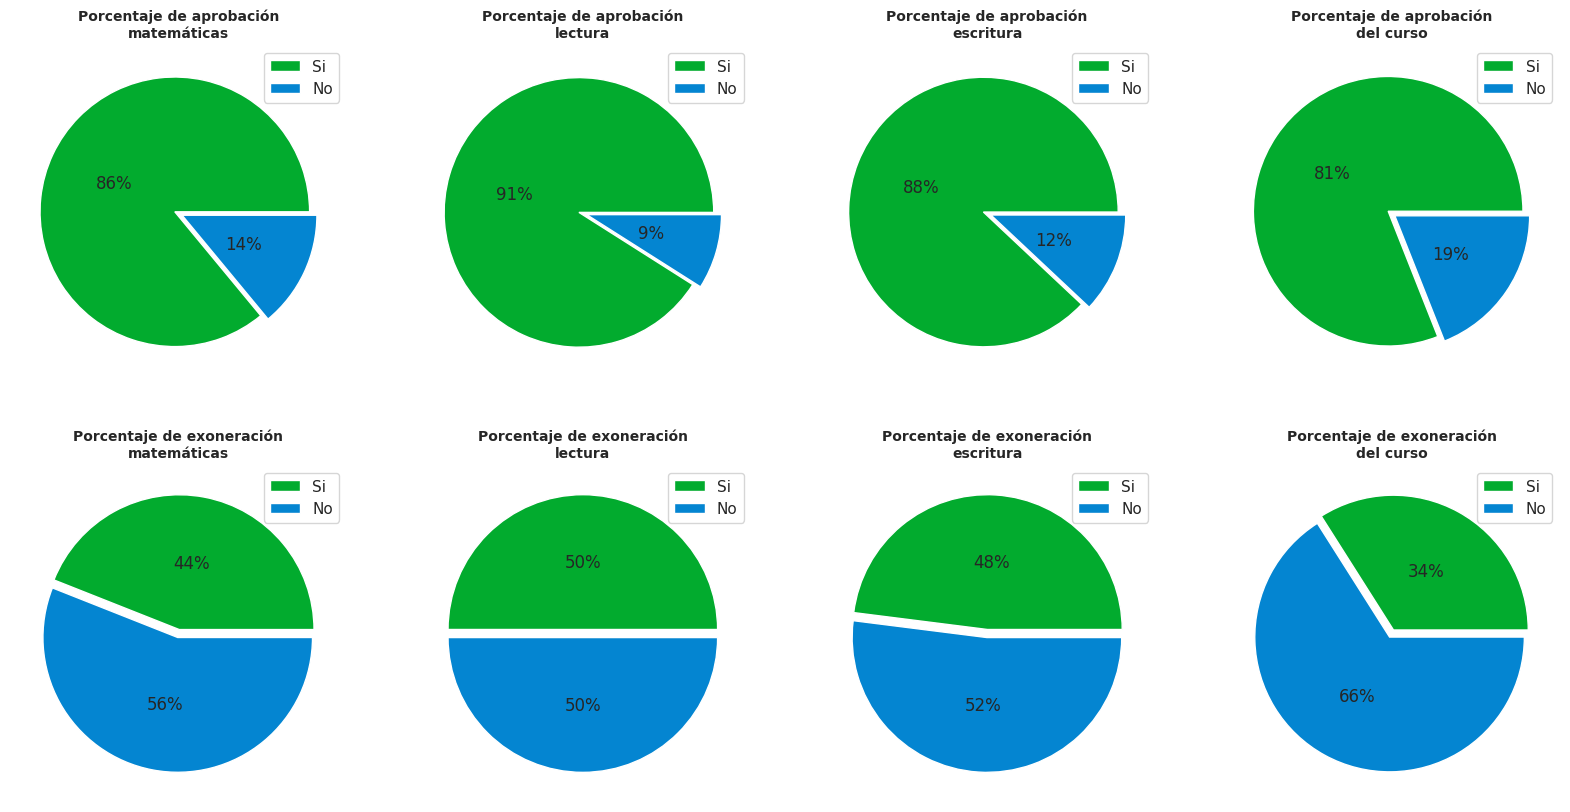

In [88]:
sns.set_theme(palette = ['#02ab2e', '#0485d1'])
fig, axs = plt.subplots(2,4, figsize=(20, 10))

ciclo = {(0,0,"Matematicas_ap"), (0,1,"Lectura_ap"), (0,2,"Escritura_ap"), (0,3,"Total_ap"), (1,0,"Matematicas_ex"), (1,1,"Lectura_ex"), (1,2,"Escritura_ex"), (1,3,"Total_ex")}
ciclo2 = {(0, "matemáticas"), (1,"lectura"), (2, "escritura"), (3,"del curso")}

for a,b,c in ciclo:
  axs[a,b].pie(Porcentajes[c], autopct='%1.0f%%', pctdistance= 0.5, labeldistance= 1.05, explode = (0.03, 0.03))
  axs[a,b].legend(Porcentajes.index, frameon = True, facecolor = 'white')

for a,b in ciclo2:
 axs[0,a].set_title("Porcentaje de aprobación\n" +b, fontsize = 10, fontweight = 'bold')

for a,b in ciclo2:
 axs[1,a].set_title("Porcentaje de exoneración\n" +b, fontsize = 10, fontweight = 'bold')

En este gráfico se presentan pieplots que indican el porcentaje de alumnos que aprueban cada examen (obtienen 50 puntos o más) y el curso (obtienen 50 puntos o más en los 3 exámenes), y el porcentaje que exonera cada asignatura (70 puntos o más) y el curso (obtienen 70 puntos o más en los 3 exámenes). Mientras que el porcentaje de aprobación del curso es del 81%, el porcentaje de axoneracióin disminuye notablemente a 34%.

<ipython-input-89-2a96ae328608>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = Estudio['Est_sem'], fontsize= 10, fontweight = 'bold')


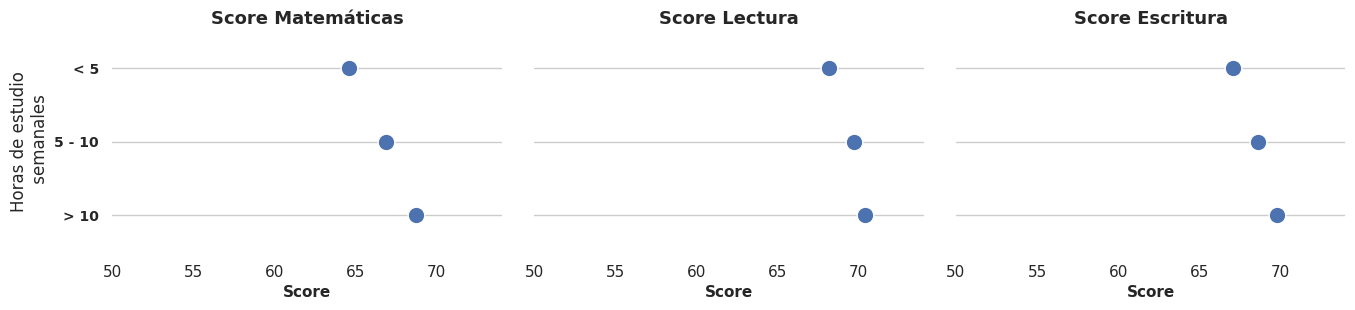

In [89]:
sns.set_theme(style="whitegrid")

E = sns.PairGrid(Estudio.sort_values("Score_total"),
                 x_vars=Estudio.columns[1:-11], y_vars= "Est_sem",
                 height=3, aspect=1.5)

E.map(sns.stripplot, size=12, orient="h", jitter=False, linewidth=1, edgecolor="w")

E.set(xlim=(50, 74), ylabel="Horas de estudio\n semanales")

titles = ["Score Matemáticas", "Score Lectura", "Score Escritura"]

for ax, title in zip(E.axes.flat, titles):
    ax.set_title(title, fontsize= 13, fontweight = 'bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_xlabel("Score", fontsize= 11, fontweight = 'bold')
    ax.set_yticklabels(labels = Estudio['Est_sem'], fontsize= 10, fontweight = 'bold')

sns.despine(left=True, bottom=True)


En este gráfico se puede apreciar el efecto positivo que tiene el aumento de las horas de estudio semanales en las calificaciones. Este efecto es más notorio en Matemáticas que en Lectura y Escritura.

### Análisis por variables biológicas

In [90]:
sns.set(font_scale=1)
sns.set_style('darkgrid')

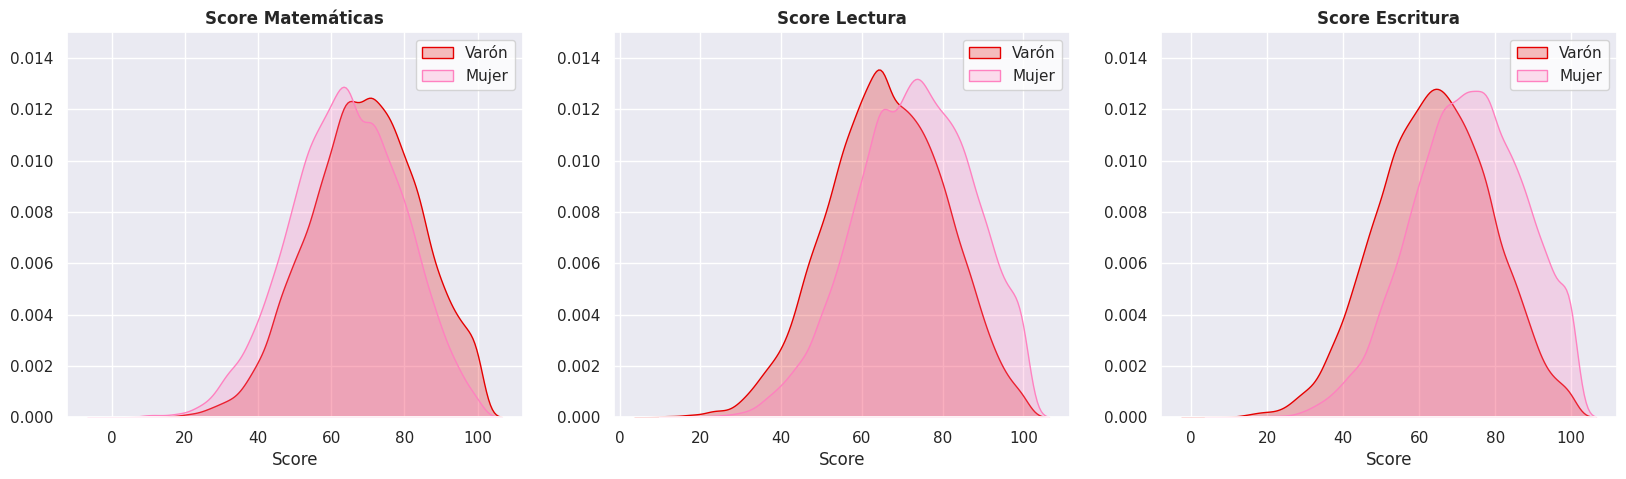

In [91]:
fig, axs = plt.subplots(1, 3, figsize= (20,5))
custom_ylim = (0, 0.015)
plt.setp(axs, ylim = custom_ylim)

sns.kdeplot(data = score, x = "Score_mat", hue= "Sexo", palette = ['#ff81c0', '#e50000'], fill = True, ax = axs[0]).set(xlabel= "Score", ylabel= "")
axs[0].set_title("Score Matemáticas", fontweight = 'bold')
axs[0].legend(labels = ['Varón', 'Mujer'], frameon = True, facecolor = 'white')
sns.kdeplot(data = score, x = "Score_lect", hue= "Sexo", palette = ['#ff81c0', '#e50000'], fill = True, ax = axs[1]).set(xlabel= "Score", ylabel= "")
axs[1].set_title("Score Lectura", fontweight = 'bold')
axs[1].legend(labels = ['Varón', 'Mujer'], frameon = True, facecolor = 'white')
sns.kdeplot(data = score, x = "Score_esc", hue= "Sexo", palette = ['#ff81c0', '#e50000'], fill = True, ax = axs[2]).set(xlabel= "Score", ylabel= "")
axs[2].set_title("Score Escritura", fontweight = 'bold')
axs[2].legend(labels = ['Varón', 'Mujer'], frameon = True, facecolor = 'white')

El gráfico triple, que muestra la distribución de la calificación de los estudiantes en los 3 tests, diferenciando por sexo.

Como resultado de estas gráficas se pueden obtener varias conclusiones. Primero que las distribuciones en todas las pruebas, tanto para hombres como para mujeres, tienen colas a la izquierda, lo que en este caso implica que las notas se presentan en menor proporción.
Otra conclusión que se puede sacar es que los hombres tienden a tener en general mejores calificaciones en matemáticas, esto se puede ver en que la distribución para los hombres se ubica más a la derecha que la de las mujeres. Por el contrario, en las pruebas de lectura y escritura las mujeres presentan mejores resultados, además la diferencia parecería ser mayor.

Text(0.5, 1.0, 'Scores promedio por sexo')

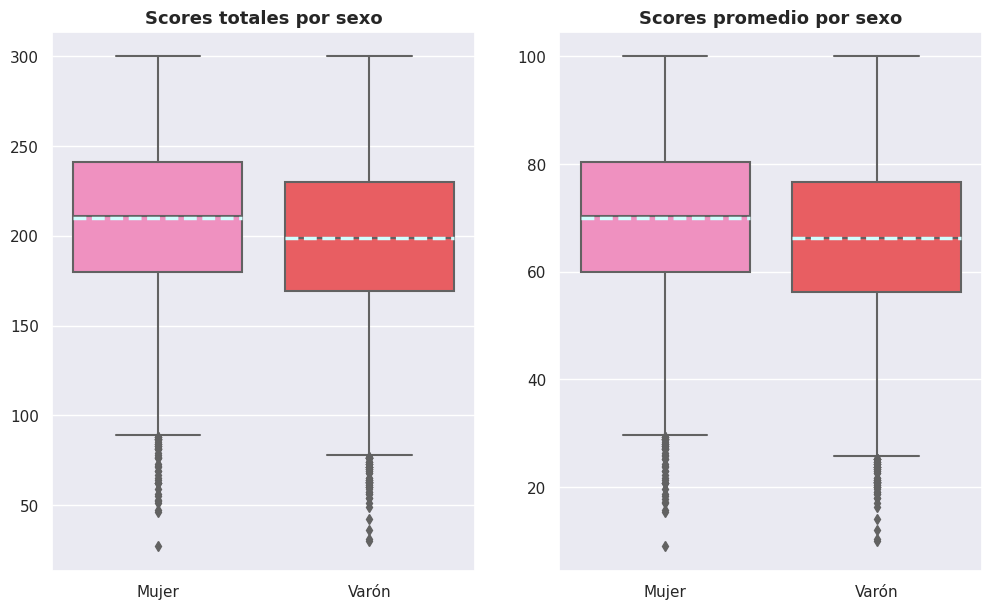

In [92]:
f, axs = plt.subplots(1,2,figsize=(12,7))

meanlineprops = dict(linestyle='--', linewidth=2.5, color='#d0fefe')
sns.boxplot(data= score, y= "Score_total", x="Sexo", palette = ['#ff81c0', '#ff474c'], showmeans = True, meanline = True, meanprops = meanlineprops, ax = axs[0]).set(ylabel = "", xlabel = "")
axs[0].set_title("Scores totales por sexo", fontweight = 'bold', fontsize = 13)
sns.boxplot(data= score, y= "Score_prom", x="Sexo", palette = ['#ff81c0', '#ff474c'], showmeans = True, meanline = True, meanprops = meanlineprops, ax = axs[1]).set(ylabel = "", xlabel = "")
axs[1].set_title("Scores promedio por sexo", fontweight = 'bold', fontsize = 13)

En este caso podemos concluir que la calificación total media de las mujeres se encuentra por encima de la calificación total media de los hombres. Además el rango intercuartílico de las mujeres es también más elevado. Esto implica que el cuartil superior de las mujeres tienen una calificación en promedio mayor al cuartil superior de los hombres. Esto mismo ocurre para los cuartiles inferiores.

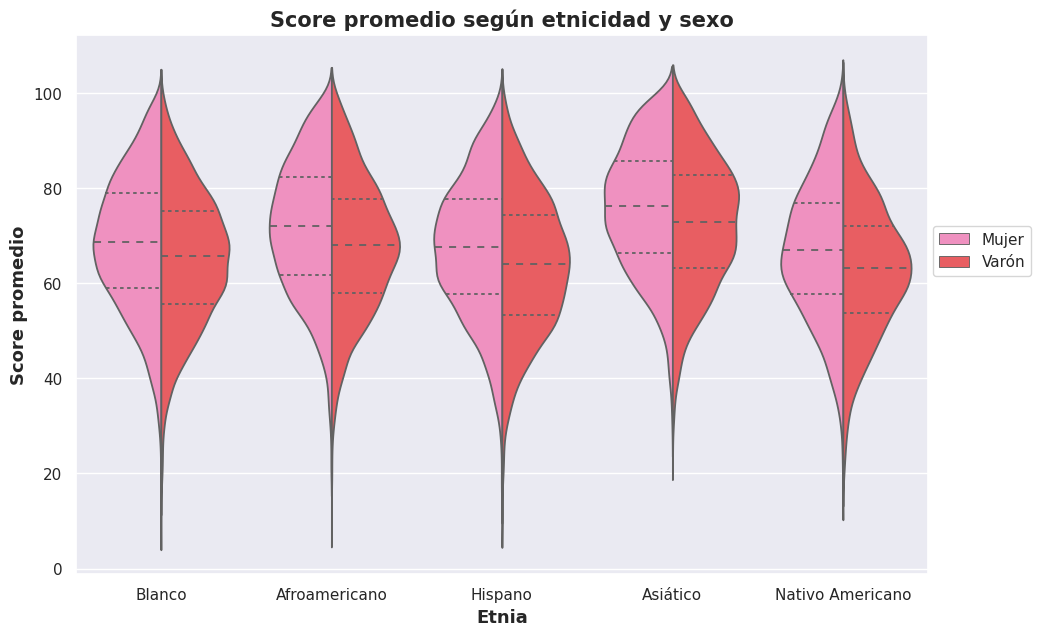

In [93]:
sns.set(font_scale=1)
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(11,7))

sns.violinplot(data=score, x = 'Etnia', y='Score_prom', hue='Sexo', split = True, order = ["Blanco", "Afroamericano", "Hispano", "Asiático", "Nativo Americano"], palette = ['#ff81c0', '#ff474c'], inner = "quartile", linewidth=1.3)
ax.set_title("Score promedio según etnicidad y sexo", fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Etnia", fontsize = 13, fontweight = 'bold')
ax.set_ylabel("Score promedio", fontsize = 13, fontweight = 'bold')
plt.legend(loc = 'center right', bbox_to_anchor=(1.13, 0.6), frameon = True, facecolor = 'white')

De este gráfico se pueden sacar dos conclusiones. La primera es que el fenómeno de que las mujeres tienen mejores calificaciones que los varones no es impulsado por ninguna etnia en particular que sea mayoritaria en la distribución de los alumnos, sino que es un fenómeno transcultural. El segundo fenómeno es que no hay mayores diferencias entre las diferentes etnicidades, solamente los alumnos asiáticos son los que presentan una distribución de calificaciones más elevada que el resto, especialmente las mujeres asiáticas.

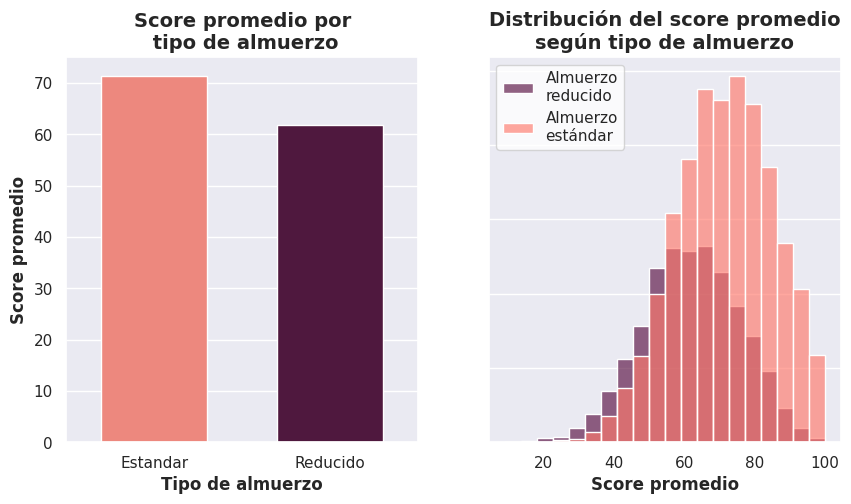

In [94]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

sns.barplot(data = score, x = "Tipo_almuerzo", y = "Score_prom", errorbar = None, width = .6, palette = ["#ff796c","#580f41"], ax = axs[0])
axs[0].set_xlabel(xlabel = "Tipo de almuerzo", fontweight = 'bold')
axs[0].set_ylabel(ylabel = "Score promedio", fontweight = 'bold')
axs[0].set_title(label = "Score promedio por\n tipo de almuerzo", fontweight = 'bold', fontsize = 14)
sns.histplot(data = score, x = "Score_prom", hue = "Tipo_almuerzo", palette = ["#ff796c","#580f41"], bins = 20, alpha = .65, ax = axs[1])
axs[1].legend(labels = ("Almuerzo\nreducido", "Almuerzo\nestándar"), frameon = True, facecolor = 'white')
axs[1].set_xlabel(xlabel = "Score promedio", fontweight = 'bold')
axs[1].set_ylabel(ylabel = "")
axs[1].set_yticklabels(labels = "")
axs[1].set_title(label = "Distribución del score promedio\nsegún tipo de almuerzo", fontweight = 'bold', fontsize = 14)
axs[1].xaxis.grid(False)
axs[1].yaxis.grid(True)

En esta gráfica se distingue el promedio entre los alumnos que consumen el almuerzo estandar y el almuerzo reducido. Podemos concluir que una peor alimentación diaria podría tener un efecto sobre las calificaciones obtenidas por los alumnos.

### Análisis por variables académicas

Text(0.5, 1.0, 'Score Escritura')

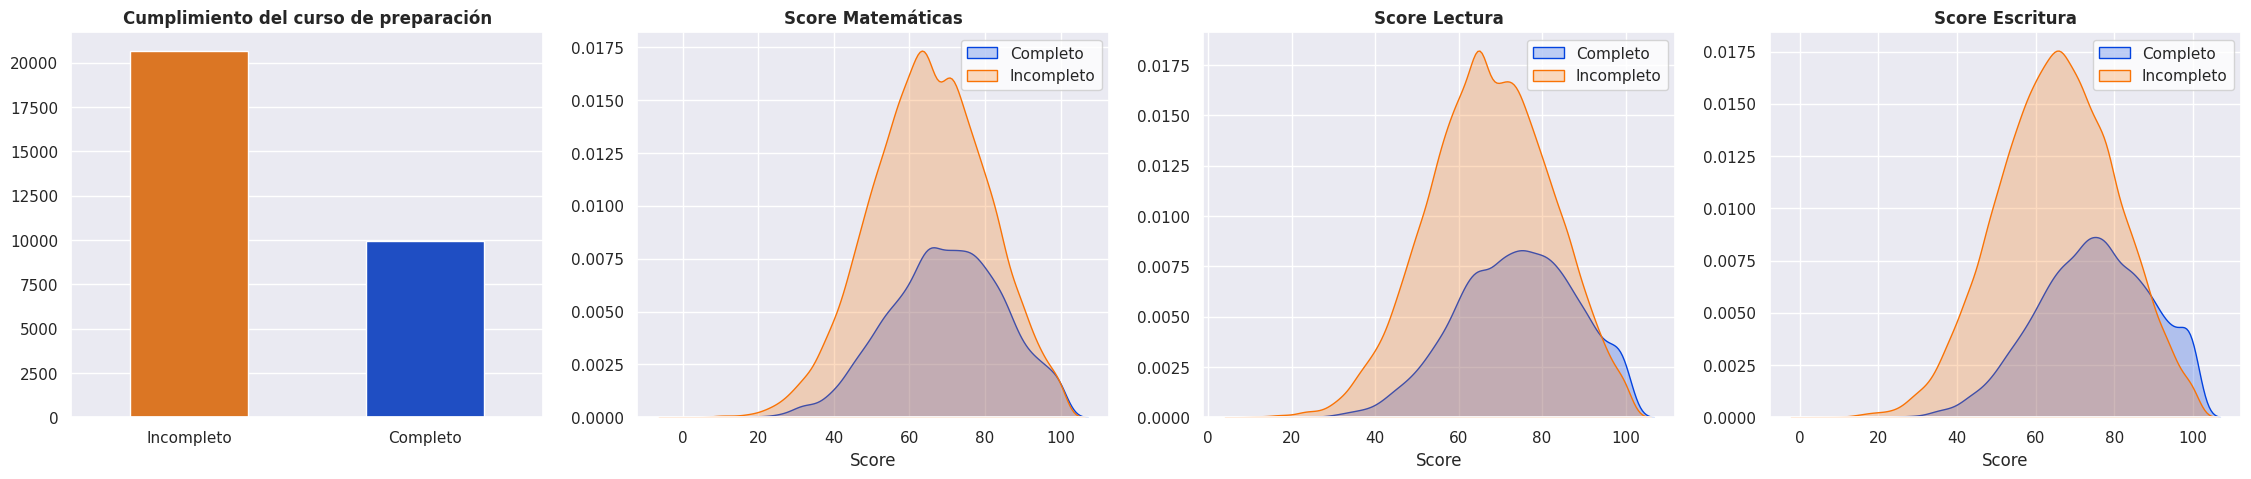

In [95]:
fig, axs = plt.subplots(1, 4, figsize= (28,5))

sns.countplot(data = score, x= "Curso_prep", width = 0.5, palette = ['#f97306', '#0343df'], ax = axs[0]).set(xlabel = "", ylabel = "")
axs[0].set_xticklabels(["Incompleto", "Completo"])
axs[0].set_title("Cumplimiento del curso de preparación", fontweight = 'bold')
sns.kdeplot(data = score, x = "Score_mat", hue= "Curso_prep", palette = ['#f97306', '#0343df'], fill = True, ax = axs[1]).set(xlabel= "Score", ylabel= "")
axs[1].legend(labels = ['Completo', 'Incompleto'], frameon = True, facecolor = 'white')
axs[1].set_title("Score Matemáticas", fontweight = 'bold')
sns.kdeplot(data = score, x = "Score_lect", hue= "Curso_prep", palette = ['#f97306', '#0343df'], fill = True, ax = axs[2]).set(xlabel= "Score", ylabel= "")
axs[2].legend(labels = ['Completo', 'Incompleto'], frameon = True, facecolor = 'white')
axs[2].set_title("Score Lectura", fontweight = 'bold')
sns.kdeplot(data = score, x = "Score_esc", hue= "Curso_prep", palette = ['#f97306', '#0343df'], fill = True, ax = axs[3]).set(xlabel= "Score", ylabel= "")
axs[3].legend(labels = ['Completo', 'Incompleto'], frameon = True, facecolor = 'white')
axs[3].set_title("Score Escritura", fontweight = 'bold')

El primer gráfico indica cuantos alumnos terminaron el curso de preparación para las pruebas y cuantos no lo hicieron, y los siguientes la distribución de calificaciones separando por la culminación del curso.

En este caso podemos ver que más de 2/3 de los alumnos no completaron el curso de preparación para los exámenes. Este fenómeno se refleja con leves diferencias entre las asignaturas. En matemáticas la distribución de los alumnos que completaron el curso es muy similar a la de los alumnos que no lo completaron, la gran diferencia es el la cantidad, pero la forma es similar, apenas más volcada a la derecha. En cambio en escritura y lectura la distribución de calificaciones de los alumnos que completaron el curso tiene una tendencia mayor a la derecha, incluso mostrando que en la parte más alta de la distribución (calificaciones más altas) hay una predominancia de alumnos que si realizaron el curso completo.

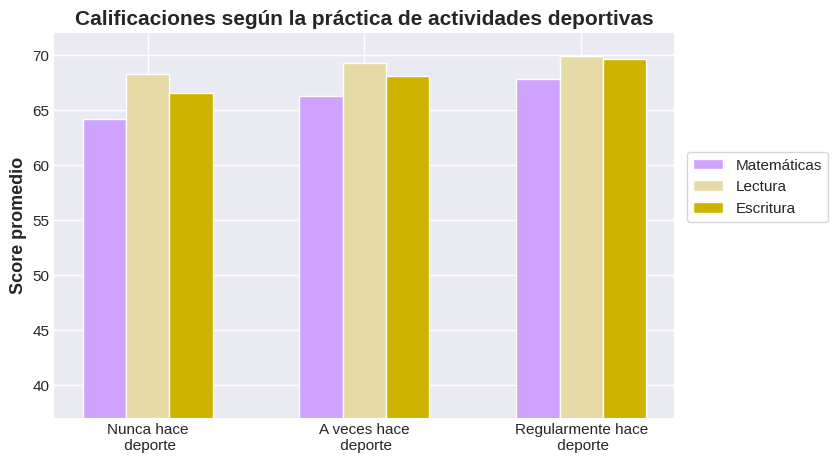

In [96]:
mpl.style.use('seaborn-v0_8-darkgrid')
rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(8,5))
custom_ylim = (37, 72)
plt.setp(ax, ylim = custom_ylim)

ax.bar(data= sport, x = sport['Category'] - 0.2, height= 'Score_mat', width = 0.2, color = '#cea2fd')
ax.bar(data= sport, x = sport['Category'], height= 'Score_lect', width = 0.2, color = '#e6daa6')
ax.bar(data= sport, x = sport['Category'] + 0.2, height= 'Score_esc', width = 0.2, color = '#ceb301')
ax.set_ylabel("Score promedio", fontsize = 13, fontweight = 'bold')
ax.set_title("Calificaciones según la práctica de actividades deportivas", fontsize = 15, fontweight = 'bold')
ax.legend(labels = ["Matemáticas", "Lectura", "Escritura"], loc = 'center right', bbox_to_anchor=(1.26, 0.6), frameon = True, facecolor = 'white')
ax.set_xticks(ticks = (1,2,3), labels = ("Nunca hace\n deporte", "A veces hace\n deporte", "Regularmente hace\n deporte"))

En esta gráfica se presetan las diferencias en las calificaciones de los tres exámenes para los alumnos según el grado de actividad deportiva que realizan. Hay una mínima tendencia a que los alumnos que realizan deporte más a menudo tienen en promedio mejores calificaciones. Cabe destacar que el efecto es marginal, por ese motivo el eje 'y' de la gráfica está recortado, para que se pueda apreciar el efecto de mejor manera.

### Análisis por variables familiares

Text(0.5, 1.0, 'Calificación según nivel educativo de los padres')

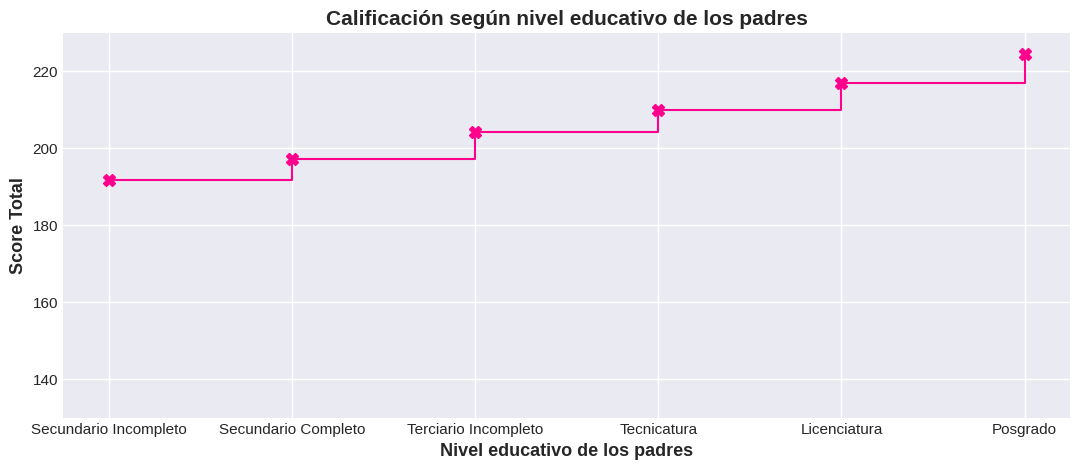

In [97]:
fig, ax = plt.subplots(figsize=(13,5))
custom_ylim = (130, 230)
plt.setp(ax, ylim = custom_ylim)

ax.plot(Educ_fam.index, Educ_fam['Score_total'], color = '#ff028d', lw = '1.5', marker = 'X', ms = '8', ds = 'steps-post')
ax.set_xlabel("Nivel educativo de los padres", fontsize = 13, fontweight = 'bold')
ax.set_ylabel("Score Total", fontsize = 13, fontweight = 'bold')
ax.set_title("Calificación según nivel educativo de los padres", fontsize = 15, fontweight = 'bold')

En este gráfico se puede concluir que los alumnos cuyos padres tienen un nivel educativo más elevado tienden a tener mejores resultados educativos.

Text(0.5, 1.0, 'Score promedio según estado civil\n de los padres')

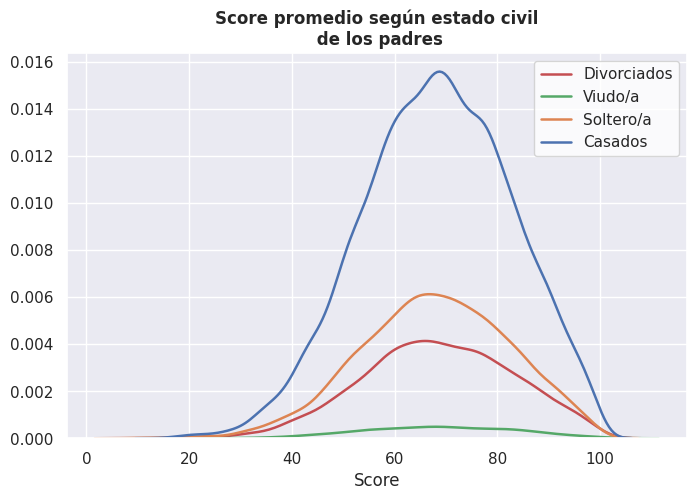

In [98]:
sns.set(font_scale=1)
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(data = score, x = "Score_prom", linewidth = 1.8, hue= "Estado_civil_padres").set(xlabel= "Score", ylabel= "")
ax.legend(labels = ["Divorciados", "Viudo/a", "Soltero/a", "Casados"], frameon = True, facecolor = 'white')
ax.set_title("Score promedio según estado civil\n de los padres", fontweight = 'bold')

Text(0, 0.5, 'Score promedio')

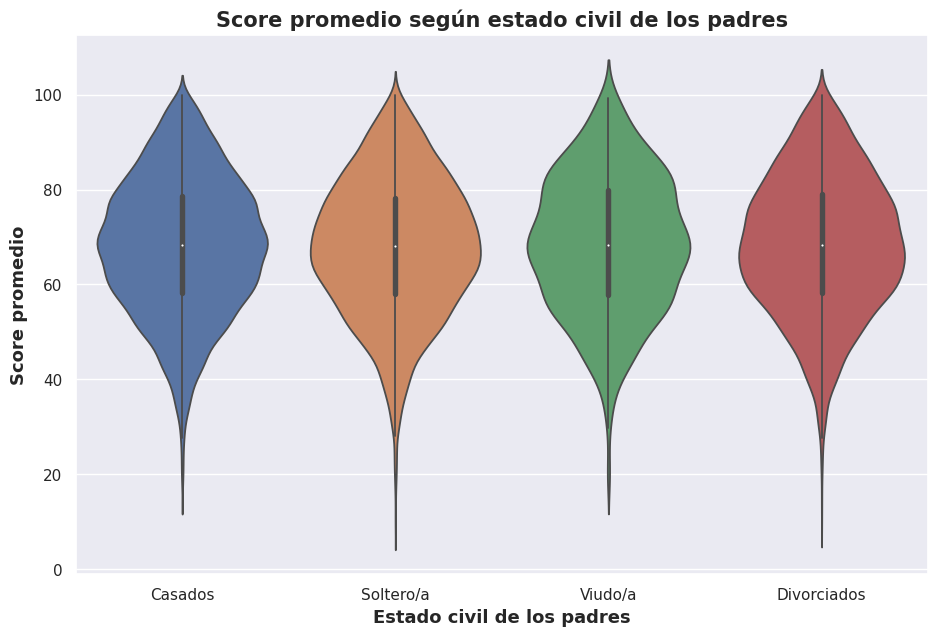

In [99]:
fig, ax = plt.subplots(figsize=(11,7))

sns.violinplot(data=score, x = 'Estado_civil_padres', y='Score_prom', split = True, linewidth=1.3)
ax.set_title("Score promedio según estado civil de los padres", fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Estado civil de los padres", fontsize = 13, fontweight = 'bold')
ax.set_ylabel("Score promedio", fontsize = 13, fontweight = 'bold')

En estos dos gráficos se puede ver que descontando la cantidad de datos no hay mayores diferencias en las calificaciones según el estado civil de los padres, probablemente no sea una buena variable para realizar predicciones.

Text(0.515, 0.98, 'Score promedio según número de hermanos')

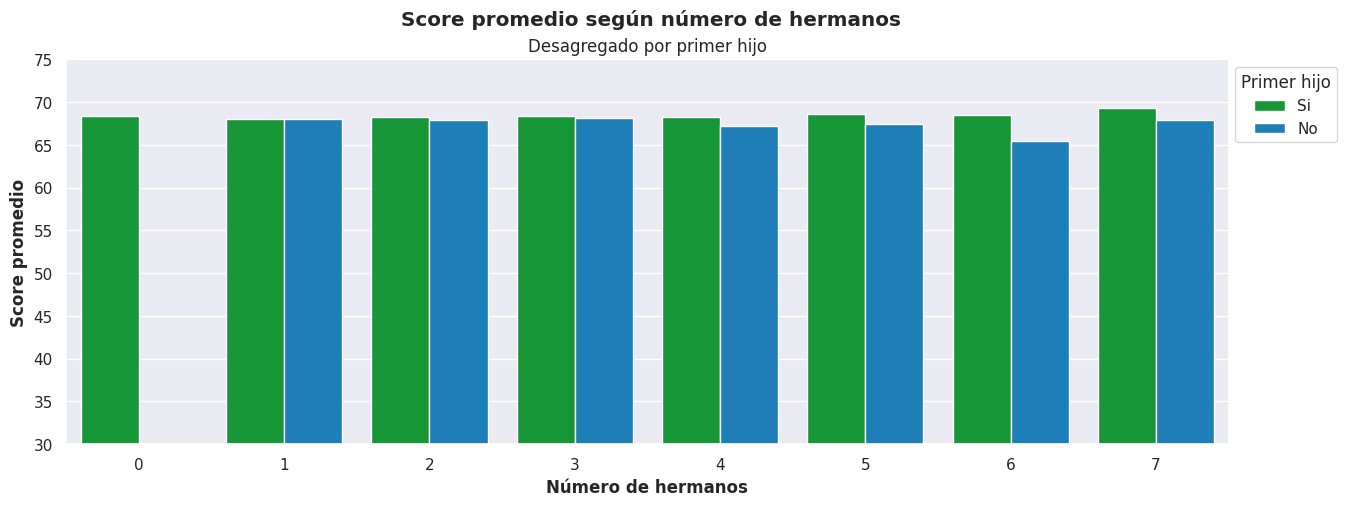

In [100]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set_theme(palette = ['#02ab2e', '#0485d1'])
custom_ylim = (30, 75)
plt.setp(ax, ylim = custom_ylim)

sns.barplot(data= score, x="Hermanos", y="Score_prom", hue="Primer_hijo", errorbar = None)
ax.set_xlabel("Número de hermanos", fontweight = 'bold')
ax.set_ylabel("Score promedio", fontweight = 'bold')
ax.legend(title= "Primer hijo", frameon = True, facecolor = 'white', loc = 1, bbox_to_anchor=(1.1, 1))
plt.title("Desagregado por primer hijo")
plt.suptitle("Score promedio según número de hermanos", x= 0.515, fontweight = 'bold')

En esta gráfica se presenta la calificación promedio del curso según el número de hermanos que tiene el alumno, y discriminado según si es o no el primer hijo. No se aprecian mayores diferencias entre el número de hermnanos para el primer hijo, pero si hay una tendencia marginal a la baja en la calificación a medida que el número de hermanos aumenta y no se es el primer hijo.

# Selección de variables para el modelo

Del análisis visual con los gráficos se vieron algunas posibles relaciones entre algunas variables con las variables que queremos explicar (aprobación y exoneración del curso). Con un modelo de regresión se consideraron cuales de esas variables realmente es útil para explicar la variable objetivo y cuales no.

Las variables string se volvieron a dtype = object para poder operar las regresiones.

In [101]:
for i in score.columns:
  if score[i].dtypes == 'string':
    score[i] = score[i].astype('object')
  else:
    pass

print(score.dtypes)

Sexo                    object
Etnia                   object
Educ_padres             object
Tipo_almuerzo           object
Curso_prep              object
Estado_civil_padres     object
Deporte                 object
Primer_hijo             object
Hermanos                 int64
Transporte              object
Estudio_semanal         object
Score_mat                int64
Score_lect               int64
Score_esc                int64
Score_total              int64
Score_prom             float64
ap_mat                   int64
ap_lect                  int64
ap_esc                   int64
ex_mat                   int64
ex_lect                  int64
ex_esc                   int64
ap_curso                 int64
ex_curso                 int64
dtype: object


Se van a eliminar las columnas de puntajes en cada prueban y de aprobación o exoneración de cada prueba, así como las de los puntajes total y promedio, ya que las mismas están correlacionadas con la variable que se intenta explicar.

Además se van a transformar las variables categóricas a dummies con one hot encoding para poder realizar el modelo de regresión logística, que es a priori el que mejor se adaptaría al problema.

In [113]:
score2 = score.drop(columns = score.iloc[:, -13:-2])
score2 = score2.drop(columns = 'ap_curso')
score2

,Sexo,Etnia,Educ_padres,Tipo_almuerzo,Curso_prep,Estado_civil_padres,Deporte,Primer_hijo,Hermanos,Transporte,Estudio_semanal,ex_curso
ID,,,,,,,,,,,,
1,Mujer,Blanco,Licenciatura,Estandar,Incompleto,Casados,Regularmente,Si,3,Bus Escolar,< 5,1
2,Mujer,Blanco,Terciario Incompleto,Estandar,Incompleto,Casados,A veces,Si,0,Bus Escolar,5 - 10,0
3,Mujer,Hispano,Posgrado,Estandar,Incompleto,Soltero/a,A veces,Si,4,Bus Escolar,< 5,1
4,Varón,Nativo Americano,Tecnicatura,Reducido,Incompleto,Casados,Nunca,No,1,Bus Escolar,5 - 10,0
5,Varón,Blanco,Terciario Incompleto,Estandar,Incompleto,Casados,A veces,Si,0,Bus Escolar,5 - 10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
30637,Mujer,Afroamericano,Secundario Completo,Estandar,Incompleto,Soltero/a,A veces,No,2,Bus Escolar,5 - 10,0
30638,Varón,Asiático,Secundario Completo,Estandar,Incompleto,Soltero/a,Regularmente,No,1,Transporte Privado,5 - 10,0
30639,Mujer,Blanco,Secundario Completo,Reducido,Completo,Casados,A veces,No,1,Transporte Privado,5 - 10,0


In [124]:
score_by = pd.get_dummies(score2, drop_first= True)
score_by

,Hermanos,ex_curso,Sexo_Varón,Etnia_Asiático,Etnia_Blanco,Etnia_Hispano,Etnia_Nativo Americano,Educ_padres_Posgrado,Educ_padres_Secundario Completo,Educ_padres_Secundario Incompleto,...,Curso_prep_Incompleto,Estado_civil_padres_Divorciados,Estado_civil_padres_Soltero/a,Estado_civil_padres_Viudo/a,Deporte_Nunca,Deporte_Regularmente,Primer_hijo_Si,Transporte_Transporte Privado,Estudio_semanal_< 5,Estudio_semanal_> 10
ID,,,,,,,,,,,,,,,,,,,,,
1,3,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,4,1,0,0,0,1,0,1,0,0,...,1,0,1,0,0,0,1,0,1,0
4,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30637,2,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
30638,1,0,1,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,0
30639,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Se separa la base ya modificada en X y Y para realizar un modelo de feature selection. En este caso backwards elimination.

In [144]:
scoreX = score_by.drop(columns = 'ex_curso')
X = scoreX

scoreY = score_by.ex_curso
Y = scoreY

In [146]:
def backward_elimination(X, Y,significance_level = 0.05):
    features = X.columns.tolist()
    while(len(features)>0):
        features_with_constant = smod.add_constant(X[features])
        p_values = smod.OLS(Y, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

backward_elimination(X,Y)

['Sexo_Varón',
 'Etnia_Asiático',
 'Etnia_Blanco',
 'Etnia_Hispano',
 'Etnia_Nativo Americano',
 'Educ_padres_Posgrado',
 'Educ_padres_Secundario Completo',
 'Educ_padres_Secundario Incompleto',
 'Educ_padres_Tecnicatura',
 'Educ_padres_Terciario Incompleto',
 'Tipo_almuerzo_Reducido',
 'Curso_prep_Incompleto',
 'Deporte_Nunca',
 'Deporte_Regularmente',
 'Primer_hijo_Si',
 'Estudio_semanal_< 5',
 'Estudio_semanal_> 10']

El resultado del feature selection indica que las variables Hermanos, Transporte y Estado_civil_padres no son relevantes para explicar la variable de exoneración del curso.

# Desarrollo del modelo

Con las siguientes líneas se separa el dataset en dos partes, un 80% del mismo que será usado para el entrenamiento del algoritmo (X_train y y_train) y el restante 20% que se utilizará luego para ver que tan efectivo resulta ser (X_test y y_test)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)

Luego de separar las variables para training y testing se estructura el algoritmo

In [148]:
LogReg = LogisticRegression()
LogReg.fit(X = X_train, y= y_train)

LogisticRegression()

 ## Métricas


Matriz de confusión

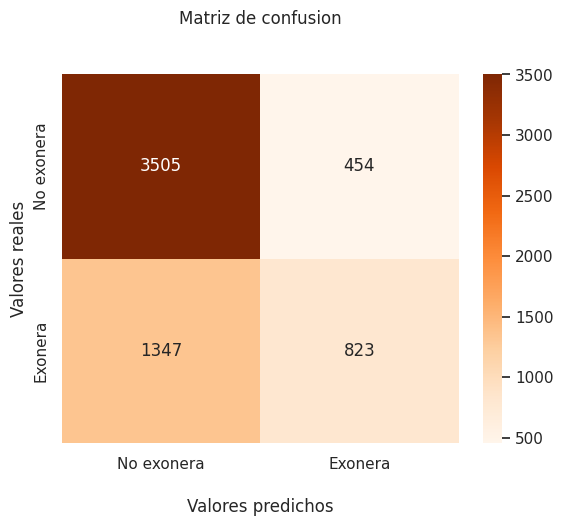

In [156]:
predicciones = LogReg.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, predicciones)

ax = sns.heatmap(conf_matrix, annot=True, fmt = ".0f", cmap='Oranges')
ax.set_title('Matriz de confusion\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales');
ax.xaxis.set_ticklabels(['No exonera','Exonera'])
ax.yaxis.set_ticklabels(['No exonera','Exonera'])
plt.show()

El algoritmo predijo que 4852 alumnos no iban a exonerar, acertando en 3505 de los casos, un 72.3% de acierto. Por otro lado predijo que 1227 iban a exonerar y acertó en 977, 67.1% de acierto. Los numeros reales del dataset para el testeo era de 3959 no exoneraciones y 2170 exoneraciones.

In [152]:
accuracy = metrics.accuracy_score(y_test, predicciones)
accuracy

0.7061510850057106

In [155]:
precision_positiva = metrics.precision_score(y_test, predicciones, pos_label=1)
precision_negativa = metrics.precision_score(y_test, predicciones, pos_label=0)
precision_positiva, precision_negativa

(0.6444792482380579, 0.7223825226710635)

El modelo es levemente mejor para predecir la no exoneración. Otra conclusión que se puede sacar de las métricas es que el mdelo tiende a sobreestimar el número de los no exonerados y subestimar el número de exonerados.